<a href="https://colab.research.google.com/github/CASAttackZW2025/CAS502Project/blob/main/CAS502testv02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpy


Job 0 arrives at 0.19
Job 0 starts processing at 0.19
Job 1 arrives at 0.42
Job 2 arrives at 0.63
Job 0 finishes at 0.70
Job 1 starts processing at 0.70
Job 1 finishes at 0.78
Job 2 starts processing at 0.78
Job 3 arrives at 0.89
Job 2 finishes at 1.87
Job 3 starts processing at 1.87
Job 4 arrives at 2.49
Job 3 finishes at 2.53
Job 4 starts processing at 2.53
Job 4 finishes at 4.27
Job 5 arrives at 4.36
Job 5 starts processing at 4.36
Job 6 arrives at 4.64
Job 7 arrives at 5.03
Job 5 finishes at 5.05
Job 6 starts processing at 5.05
Job 6 finishes at 5.80
Job 7 starts processing at 5.80
Job 8 arrives at 6.23
Job 7 finishes at 6.52
Job 8 starts processing at 6.52
Job 9 arrives at 6.96
Job 10 arrives at 7.40
Job 8 finishes at 7.61
Job 9 starts processing at 7.61
Job 9 finishes at 7.69
Job 10 starts processing at 7.69
Job 11 arrives at 7.88
Job 12 arrives at 7.97
Job 10 finishes at 8.31
Job 11 starts processing at 8.31
Job 13 arrives at 9.75
Job 11 finishes at 9.76
Job 12 starts processing

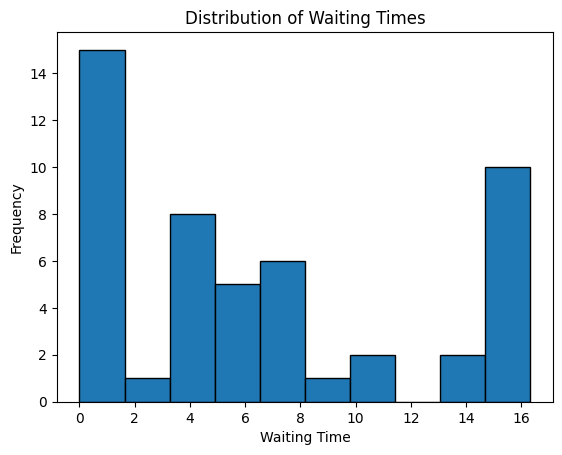

In [ ]:
import simpy
import random
import matplotlib.pyplot as plt

num_jobs = 50
arrival_rate = 1.0
processing_rate = 1.0


def job(env, name, processor, wait_times):
    arrival_time = env.now
    print(f'Job {name} arrives at {arrival_time:.2f}')
    with processor.request() as request:
        yield request
        start_time = env.now
        print(f'Job {name} starts processing at {start_time:.2f}')
        processing_time = random.expovariate(processing_rate)
        yield env.timeout(processing_time)
        finish_time = env.now
        print(f'Job {name} finishes at {finish_time:.2f}')
        wait_time = start_time - arrival_time
        wait_times.append(wait_time)

def job_generator(env, processor, wait_times):
    for i in range(num_jobs):
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(job(env, i, processor, wait_times))

def run_simulation():
    env = simpy.Environment()
    processor = simpy.Resource(env, capacity=1)
    wait_times = []
    env.process(job_generator(env, processor, wait_times))
    env.run()
    print(f"Average waiting time: {sum(wait_times)/len(wait_times):.2f}")
    plt.hist(wait_times, bins=10, edgecolor='black')
    plt.title('Distribution of Waiting Times')
    plt.xlabel('Waiting Time')
    plt.ylabel('Frequency')
    plt.show()

# Run simulation
run_sim()


In [2]:
import simpy
import random
import matplotlib.pyplot as plt


In [3]:
num_jobs = 50
arrival_rate = 1.0
processing_rate = 1.0

num_workers = 3
num_cranes = 1
num_test_kits = 1


crane_prob = 0.5
test_kit_prob = 0.3

shift_length = 6.5
break_length = 1.5
cycle_length = shift_length + break_length

In [4]:
def process_during_shift(env, processing_time):
    remaining = processing_time
    while remaining > 0:
        cycle_time = env.now % cycle_length
        if cycle_time >= shift_length:
            wait_time = cycle_length - cycle_time
            yield env.timeout(wait_time)
        else:
            work_time_left = shift_length - cycle_time
            dt = min(remaining, work_time_left)
            yield env.timeout(dt)
            remaining -= dt

def job(env, name, worker, crane, test_kit, wait_times):
    arrival_time = env.now
    print(f'Job {name} arrives at {arrival_time:.2f}')

    with worker.request() as req:
        yield req
        needs_crane = random.random() < crane_prob
        needs_test_kit = random.random() < test_kit_prob
        processing_time = random.expovariate(processing_rate)
        start_time = env.now

        if needs_crane and needs_test_kit:
            with crane.request() as req_crane:
                yield req_crane
                with test_kit.request() as req_test:
                    yield req_test
                    print(f'Job {name} starts processing at {start_time:.2f} (with crane and test kit)')
                    yield from process_during_shift(env, processing_time)
                    finish_time = env.now
                    print(f'Job {name} finishes at {finish_time:.2f}')
        elif needs_crane:
            with crane.request() as req_crane:
                yield req_crane
                print(f'Job {name} starts processing at {start_time:.2f} (with crane)')
                yield from process_during_shift(env, processing_time)
                finish_time = env.now
                print(f'Job {name} finishes at {finish_time:.2f}')
        elif needs_test_kit:
            with test_kit.request() as req_test:
                yield req_test
                print(f'Job {name} starts processing at {start_time:.2f} (with test kit)')
                yield from process_during_shift(env, processing_time)
                finish_time = env.now
                print(f'Job {name} finishes at {finish_time:.2f}')
        else:
            print(f'Job {name} starts processing at {start_time:.2f}')
            yield from process_during_shift(env, processing_time)
            finish_time = env.now
            print(f'Job {name} finishes at {finish_time:.2f}')

        wait_times.append(start_time - arrival_time)

def job_generator(env, worker, crane, test_kit, wait_times):
    for i in range(num_jobs):
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(job(env, i, worker, crane, test_kit, wait_times))



Job 0 arrives at 3.94
Job 0 starts processing at 3.94
Job 0 finishes at 4.68
Job 1 arrives at 4.94
Job 1 starts processing at 4.94
Job 2 arrives at 6.93
Job 2 starts processing at 6.93 (with test kit)
Job 3 arrives at 7.26
Job 4 arrives at 9.46
Job 1 finishes at 9.76
Job 2 finishes at 9.98
Job 3 starts processing at 7.26 (with crane and test kit)
Job 3 finishes at 10.01
Job 4 starts processing at 9.76 (with crane)
Job 4 finishes at 10.30
Job 5 arrives at 10.93
Job 5 starts processing at 10.93
Job 6 arrives at 12.70
Job 6 starts processing at 12.70
Job 6 finishes at 12.71
Job 7 arrives at 13.40
Job 7 starts processing at 13.40 (with crane and test kit)
Job 7 finishes at 13.54
Job 5 finishes at 13.97
Job 8 arrives at 14.04
Job 8 starts processing at 14.04 (with crane)
Job 9 arrives at 14.69
Job 10 arrives at 15.04
Job 10 starts processing at 15.04
Job 8 finishes at 16.04
Job 9 starts processing at 14.69 (with crane)
Job 11 arrives at 16.36
Job 10 finishes at 17.44
Job 12 arrives at 17.98

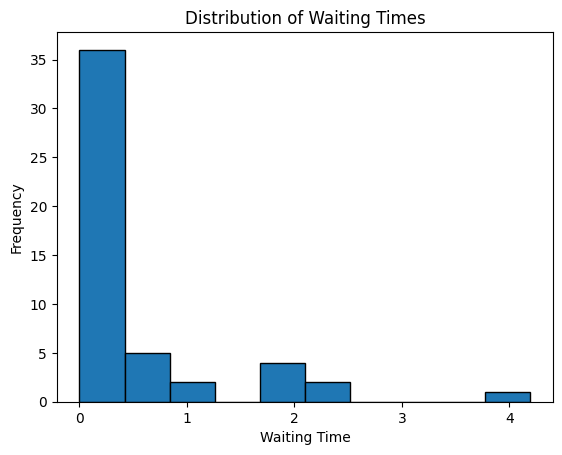

In [5]:
def run_simulation():
    env = simpy.Environment()

    worker = simpy.Resource(env, capacity=num_workers)
    crane = simpy.Resource(env, capacity=num_cranes)
    test_kit = simpy.Resource(env, capacity=num_test_kits)

    wait_times = []
    env.process(job_generator(env, worker, crane, test_kit, wait_times))
    env.run()

    if wait_times:
        avg_wait = sum(wait_times) / len(wait_times)
        print(f"\nAverage waiting time: {avg_wait:.2f} time units")
        plt.hist(wait_times, bins=10, edgecolor='black')
        plt.title('Distribution of Waiting Times')
        plt.xlabel('Waiting Time')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No jobs were processed.")


run_simulation()